# China data
Data from Chinese population.

See He et al. 2018 - https://doi.org/10.1038/s41591-018-0164-x

## Libraries

In [2]:
library(cowplot)
library(ggplot2)
library(tidyverse)
library(knitr)
library(broom)
library(lspline)
library(scales)

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ dplyr   0.7.6
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ cowplot::ggsave() masks ggplot2::ggsave()
✖ dplyr::lag()      masks stats::lag()

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



## Load data

Combine alpha result to mapping file

In [3]:
mapping_file = read.table("./data/China_mapping.txt", header = TRUE, comment.char = '', sep = "\t", check.names = FALSE)
mapping_file %>% 
    select("#SampleID","BarcodeSequence","age","sex","bmi","antibiotics","Description") %>% 
    head()

#SampleID,BarcodeSequence,age,sex,bmi,antibiotics,Description
11757.G441802339,TCATGCCTTTACCGGTCG,45,male,27.1,y,sample G441802339
11757.G440305397,ATTATCGTGTGAATATCG,33,female,26.2,n,sample G440305397
11757.G440981185,AGATCCGCCAGATTGCCA,73,female,22.8,n,sample G440981185
11757.G440606309,TTCTTCTAGATACCGGTT,46,male,27.2,n,sample G440606309
11757.G440606308,TTAGGAGTAATACCGGTT,27,male,16.9,n,sample G440606308
11757.G440606307,TTAGCTCATATACCGGTT,59,female,30.2,n,sample G440606307


In [4]:
select_table = mapping_file %>% 
    select("#SampleID","BarcodeSequence","age","sex","bmi","antibiotics","Description")

In [5]:
otus_1250 = read.table("./data/alpha-diversity_otus_1250.tsv", header = TRUE, sep="\t", check.names = FALSE, colClasses = c("character","numeric"))
shannon_1250 = read.table("./data/alpha-diversity_shannon_1250.tsv", header = TRUE, sep = "\t", check.names = FALSE,colClasses = c("character","numeric"))
alpha_1250 = merge.data.frame(otus_1250,shannon_1250)

In [6]:
names(alpha_1250) = c("#SampleID","observed_otus_1250","shannon_1250")
alpha_data = alpha_1250

In [7]:
combine_table = merge(select_table, alpha_data, by = "#SampleID")

In [8]:
health_table = subset(combine_table, age>=20 & age <=69 & antibiotics == "n" & bmi >=18.5 & bmi <= 30.0)

In [9]:
health_table$Description = NA
health_table$Description[health_table$age <=45] = "Young"
health_table$Description[health_table$age >45] = "Old"
health_table$Description = factor(health_table$Description, levels=c("Young","Old"))

In [10]:
health_table %>% 
    group_by(sex, Description) %>% 
    summarise(mean_age = mean(age), sd_age = sd(age), n = n())

sex,Description,mean_age,sd_age,n
female,Young,35.16490,6.732711,946
female,Old,56.59146,6.591868,1826
male,Young,34.88060,7.069424,670
male,Old,57.36029,6.750466,1521


In [11]:
health_table %>% head

,#SampleID,BarcodeSequence,age,sex,bmi,antibiotics,Description,observed_otus_1250,shannon_1250
2,11757.G440104003,TTATATGCGAACTCCATT,69,male,22.0,n,Old,80,4.290298
4,11757.G440104005,TTAAGGAAGAACTCCATT,39,male,22.3,n,Young,80,4.334422
7,11757.G440104008,TTAGCTCATAACTCCATT,68,male,22.8,n,Old,74,4.203152
9,11757.G440104013,TTCTTCTAGAACTCCATT,62,female,22.0,n,Old,122,5.019128
10,11757.G440104014,TTCTAGATCAACTCCATT,64,male,24.1,n,Old,120,5.310091
11,11757.G440104015,TTCATTCCAAACTCCATT,64,male,22.5,n,Old,120,5.257573


## Compare linear model and spline regression of alpha-diversity and age

In [12]:
# SV Richness
rich_null = lm(observed_otus_1250~1, data = health_table)
rich_lm = lm(observed_otus_1250~age, data = health_table)
rich_ls = lm(observed_otus_1250~lspline(age, c(45)), data = health_table)

AIC_rich = c(fit0 = AIC(rich_null), fit1 = AIC(rich_lm), fit2 = AIC(rich_ls)) %>%
    print

summary(rich_ls)

# Shannon
shannon_null = lm(shannon_1250~1, data = health_table)
shannon_lm = lm(shannon_1250~age, data = health_table)
shannon_ls = lm(shannon_1250~lspline(age, c(45)), data = health_table)

AIC_shannon = c(fit0 = AIC(shannon_null), fit1 = AIC(shannon_lm), fit2 = AIC(shannon_ls)) %>%
    print

    fit0     fit1     fit2 
47230.98 47231.90 47231.52 



Call:
lm(formula = observed_otus_1250 ~ lspline(age, c(45)), data = health_table)

Residuals:
    Min      1Q  Median      3Q     Max 
-77.517 -19.556  -1.195  19.204 238.939 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          98.23292    3.06098  32.092   <2e-16 ***
lspline(age, c(45))1  0.07636    0.07844   0.974   0.3303    
lspline(age, c(45))2 -0.11341    0.06102  -1.859   0.0631 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 28.19 on 4960 degrees of freedom
Multiple R-squared:  0.0006965,	Adjusted R-squared:  0.0002936 
F-statistic: 1.729 on 2 and 4960 DF,  p-value: 0.1777


    fit0     fit1     fit2 
13132.91 13119.24 13116.77 


## Plots of alpha diversity, age and sex

In [13]:
health_table$Description = factor(health_table$Description, levels=c("Young","Old"))
labels = c(Young = "20 - 45", Old = "46-69")

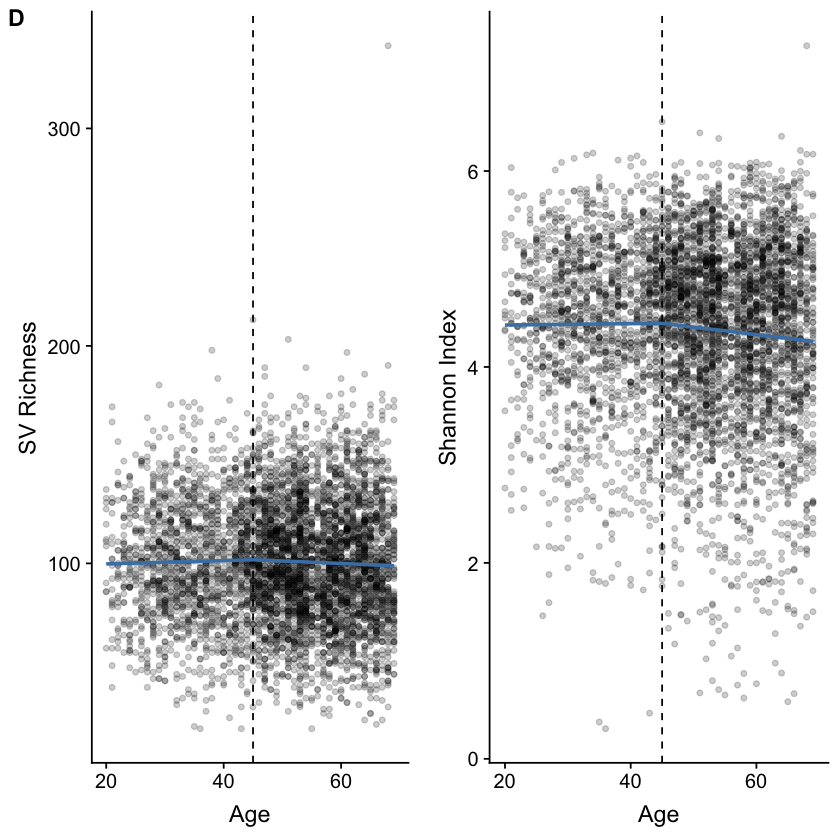

In [14]:
China_richness_spline = ggplot(health_table, aes(x = age, y = observed_otus_1250)) +
    geom_point(size = 1.3, alpha = 0.2) +
    geom_vline(xintercept = c(45), linetype="dashed") +
    geom_smooth(method = "lm", formula = y~lspline(x,c(45)), se = F, color = "steelblue") +
    labs(x = "Age", y = "SV Richness") +
    scale_x_continuous(breaks = pretty_breaks(n = 3))
    
China_shannon_spline = ggplot(health_table,  aes(x = age, y = shannon_1250)) +
    geom_point(size = 1.3, alpha = 0.2) +
    geom_vline(xintercept = c(45), linetype="dashed") +
    geom_smooth(method = "lm", formula = y~lspline(x,c(45)), se = F, color = "steelblue") +
    labs(x = "Age", y = "Shannon Index") +
    scale_x_continuous(breaks = pretty_breaks(n = 3))
 

China_div_spline = plot_grid(China_richness_spline, China_shannon_spline, nrow = 1, labels = c("D", ""))
ggsave(filename = "./images/China_alpha_spline.png", 
       plot = China_div_spline, width = 7, height = 3,
       device = "png", dpi = "print")
plot(China_div_spline)

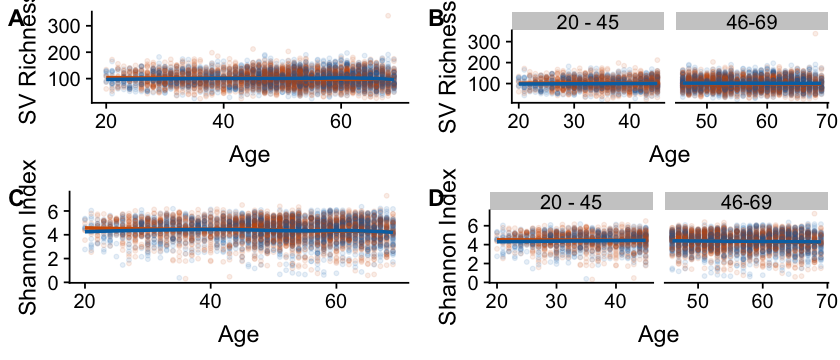

In [15]:
# Plots
options(repr.plot.width=7, repr.plot.height=3)

richness_1250 = ggplot(health_table, aes(x= age, y = observed_otus_1250, color = sex)) + 
    geom_point(size = 1, alpha = 0.1) + 
    geom_smooth(method="loess", se = F) + 
    labs(x = "Age", y = "SV Richness") +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    scale_x_continuous(breaks = pretty_breaks(n = 3)) +
    theme(legend.position="none")

shannon_1250 = ggplot(health_table, aes(x = age, y = shannon_1250, color = sex)) + 
    geom_point(size=1, alpha = 0.1) + 
    geom_smooth(method="loess", se = F) + 
    labs(x = "Age", y = "Shannon Index") +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    scale_x_continuous(breaks = pretty_breaks(n = 3)) +
    theme(legend.position="none")

richness_age_group_1250 = ggplot(health_table, aes(x = age, y = observed_otus_1250, color = sex)) +
    geom_point(size=1, alpha = 0.1) + 
    geom_smooth(method="lm", se = F) + 
    facet_wrap(~Description, scales = "free_x", labeller = labeller(Description = labels)) + 
    labs(x = "Age", y = "SV Richness") +
    scale_x_continuous(breaks = c(20,30,40,50,60,70)) +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    theme(legend.position="none")

shannon_age_group_1250 = ggplot(health_table, aes(x = age, y = shannon_1250, color = sex)) +
    geom_point(size=1, alpha = 0.1) + 
    geom_smooth(method="lm", se = F) + 
    facet_wrap(~ Description, scales = "free_x", labeller = labeller(Description = labels)) + 
    labs(x = "Age", y = "Shannon Index") +
    scale_x_continuous(breaks = c(20,30,40,50,60,70)) +
    scale_color_manual(values = c("#D55E00", "#0072B2"), labels = c("Female", "Male")) +
    theme(legend.position="none")

combine_plot = plot_grid(richness_1250, richness_age_group_1250, shannon_1250, shannon_age_group_1250, ncol = 2, labels = "AUTO")
combine_plot

In [16]:
# Manuscript plots
rich_gph = plot_grid(richness_1250, richness_age_group_1250, ncol = 2, labels = c("D", ""))
shannon_gph = plot_grid(shannon_1250, shannon_age_group_1250, ncol = 2, labels = c("D", ""))

ggsave(filename = "./images/China_rich_gph.png", plot = rich_gph, 
       width = 7, height = 3, 
       device = "png", dpi = "print")

ggsave(filename = "./images/China_shannon_gph.png", plot = shannon_gph, 
       width = 7, height = 3,
       device = "png", dpi = "print")

## Linear models

In [17]:
# Empty data frame for p-values
pvals = data.frame(Population = character(), Metric = character(), Test = character(), pval = numeric())

In [18]:
health_table %>% group_by(Description, sex) %>%
    summarise(V1=cor(observed_otus_1250, age, method = "pearson"))

Description,sex,V1
Young,female,0.01173496
Young,male,0.03064039
Old,female,-0.03926253
Old,male,-0.01438870


In [19]:
health_table %>% group_by(Description, sex) %>%
    summarise(V1=cor(shannon_1250, age, method = "pearson"))

Description,sex,V1
Young,female,-0.01978125
Young,male,0.05035293
Old,female,-0.06523570
Old,male,-0.03599425


In [20]:
otu_lm_young = lm(observed_otus_1250 ~ age, data = health_table[which(health_table$Description == "Young"),])
summary(otu_lm_young)

sv_age_y = summary(otu_lm_young) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "Chn", Metric = "Richness", Test = "age_young", pval = sv_age_y))


Call:
lm(formula = observed_otus_1250 ~ age, data = health_table[which(health_table$Description == 
    "Young"), ])

Residuals:
    Min      1Q  Median      3Q     Max 
-77.572 -18.653  -0.734  19.404 110.266 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 98.10008    3.53397  27.759   <2e-16 ***
age          0.08075    0.09895   0.816    0.415    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.33 on 1614 degrees of freedom
Multiple R-squared:  0.0004124,	Adjusted R-squared:  -0.0002069 
F-statistic: 0.6659 on 1 and 1614 DF,  p-value: 0.4146


In [21]:
otu_lm_middle = lm(observed_otus_1250 ~ age, data = health_table[which(health_table$Description == "Old"),])
summary(otu_lm_middle)

sv_age_m = summary(otu_lm_middle) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "Chn", Metric = "Richness", Test = "age_middle", pval = sv_age_m))


Call:
lm(formula = observed_otus_1250 ~ age, data = health_table[which(health_table$Description == 
    "Old"), ])

Residuals:
    Min      1Q  Median      3Q     Max 
-76.520 -20.023  -1.516  19.035 238.919 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 106.60957    4.24643  25.106   <2e-16 ***
age          -0.11072    0.07407  -1.495    0.135    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 28.6 on 3345 degrees of freedom
Multiple R-squared:  0.0006676,	Adjusted R-squared:  0.0003688 
F-statistic: 2.235 on 1 and 3345 DF,  p-value: 0.1351


In [22]:
shannon_lm_young = lm(shannon_1250 ~ age, data = health_table[which(health_table$Description == "Young"),])
summary(shannon_lm_young)

sh_age_y = summary(shannon_lm_young) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "Chn", Metric = "Shannon", Test = "age_young", pval = sh_age_y))


Call:
lm(formula = shannon_1250 ~ age, data = health_table[which(health_table$Description == 
    "Young"), ])

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1350 -0.4518  0.1079  0.6024  2.0474 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.394295   0.109218   40.23   <2e-16 ***
age         0.001346   0.003058    0.44     0.66    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8447 on 1614 degrees of freedom
Multiple R-squared:  0.00012,	Adjusted R-squared:  -0.0004995 
F-statistic: 0.1938 on 1 and 1614 DF,  p-value: 0.6599


In [23]:
shannon_lm_middle = lm(shannon_1250 ~ age, data = health_table[which(health_table$Description == "Old"),])
summary(shannon_lm_middle)

sh_age_m = summary(shannon_lm_middle) %>%
    pluck(coefficients) %>% 
    as.data.frame %>% 
    select('Pr(>|t|)') %>% 
    slice(2) %>%
    as.numeric

pvals = rbind(pvals, data.frame(Population = "Chn", Metric = "Shannon", Test = "age_middle", pval = sh_age_m))


Call:
lm(formula = shannon_1250 ~ age, data = health_table[which(health_table$Description == 
    "Old"), ])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7236 -0.5431  0.1331  0.6744  3.0066 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.765827   0.138872  34.318  < 2e-16 ***
age         -0.007262   0.002422  -2.998  0.00274 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9352 on 3345 degrees of freedom
Multiple R-squared:  0.00268,	Adjusted R-squared:  0.002382 
F-statistic: 8.988 on 1 and 3345 DF,  p-value: 0.002738


### ANCOVA of alpha-diversity and sex

In [24]:
# OTU richness
# With interaction
otu_ancova = lm(observed_otus_1250 ~ sex * age, data = health_table)
summary(otu_ancova)


Call:
lm(formula = observed_otus_1250 ~ sex * age, data = health_table)

Residuals:
    Min      1Q  Median      3Q     Max 
-77.660 -19.648  -1.202  18.943 239.759 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 105.50651    2.23839  47.135   <2e-16 ***
sexmale      -7.27069    3.37132  -2.157   0.0311 *  
age          -0.10685    0.04410  -2.423   0.0154 *  
sexmale:age   0.15857    0.06555   2.419   0.0156 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 28.18 on 4959 degrees of freedom
Multiple R-squared:  0.001525,	Adjusted R-squared:  0.0009208 
F-statistic: 2.524 on 3 and 4959 DF,  p-value: 0.05583


In [25]:
# OTU
# Without interaction
otu_anova = lm(observed_otus_1250 ~ sex + age, data = health_table)
summary(otu_anova)


Call:
lm(formula = observed_otus_1250 ~ sex + age, data = health_table)

Residuals:
    Min      1Q  Median      3Q     Max 
-76.706 -19.698  -1.181  19.170 238.415 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 101.96852    1.69542  60.144   <2e-16 ***
sexmale       0.64843    0.80691   0.804    0.422    
age          -0.03506    0.03264  -1.074    0.283    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 28.19 on 4960 degrees of freedom
Multiple R-squared:  0.0003464,	Adjusted R-squared:  -5.665e-05 
F-statistic: 0.8595 on 2 and 4960 DF,  p-value: 0.4235


In [26]:
# Shannon
# With interaction
shannon_ancova = lm(shannon_1250 ~ sex * age, data = health_table)
summary(shannon_ancova)


Call:
lm(formula = shannon_1250 ~ sex * age, data = health_table)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1661 -0.5138  0.1268  0.6461  2.9930 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.685574   0.072024  65.055  < 2e-16 ***
sexmale     -0.224122   0.108478  -2.066   0.0389 *  
age         -0.005881   0.001419  -4.144 3.47e-05 ***
sexmale:age  0.003933   0.002109   1.865   0.0623 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9067 on 4959 degrees of freedom
Multiple R-squared:  0.004081,	Adjusted R-squared:  0.003478 
F-statistic: 6.773 on 3 and 4959 DF,  p-value: 0.0001486


In [27]:
# Shannon
# Without interaction
shannon_anova = lm(shannon_1250 ~ sex + age, data = health_table)
summary(shannon_anova)


Call:
lm(formula = shannon_1250 ~ sex + age, data = health_table)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1425 -0.5051  0.1228  0.6461  2.9596 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.59783    0.05454  84.302  < 2e-16 ***
sexmale     -0.02772    0.02596  -1.068    0.286    
age         -0.00410    0.00105  -3.905 9.57e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.907 on 4960 degrees of freedom
Multiple R-squared:  0.003382,	Adjusted R-squared:  0.00298 
F-statistic: 8.416 on 2 and 4960 DF,  p-value: 0.0002244


### Fit separate linear models by each age group

In [28]:
# OTU richness
# Without interaction
otu_group_lm = health_table %>% group_by(Description) %>%
    do (otu_lm = lm (observed_otus_1250 ~ sex + age, data=.))

otu_group_coef = tidy(otu_group_lm, otu_lm)
otu_group_coef

otu_group_R2 = glance(otu_group_lm, otu_lm)
otu_group_R2

sv_age_sex_y = otu_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Young" & term == "sexmale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Chn", Metric = "Richness", Test = "age_sex_young", pval = sv_age_sex_y))

sv_age_sex_m = otu_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Old" & term == "sexmale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Chn", Metric = "Richness", Test = "age_sex_middle", pval = sv_age_sex_m))

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),99.09830587,3.59043201,27.6006636,1.144954e-137
Young,sexmale,-2.14294191,1.37983944,-1.5530371,1.206104e-01
Young,age,0.07761687,0.09892856,0.7845749,4.328180e-01
Old,(Intercept),106.17933257,4.24954958,24.9860204,1.765822e-126
Old,sexmale,2.04173208,0.99387636,2.0543120,4.002307e-02
Old,age,-0.11945945,0.07415567,-1.6109281,1.072898e-01


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.001904880,0.0006673161,27.32125,1.539218,0.21486387,3,-7636.69,15281.38,15302.93,1204025,1613
Old,0.001927157,0.0013302233,28.58273,3.228428,0.03974326,3,-15969.52,31947.04,31971.50,2731956,3344


In [29]:
# OTU
# With interaction
otu_group_anc = health_table %>% group_by(Description) %>%
    do (otu_anc = lm (observed_otus_1250 ~ sex * age, data=.))

otu_anc_group_coef = tidy(otu_group_anc, otu_anc)
otu_anc_group_coef

otu_anc_group_R2 = glance(otu_group_anc, otu_anc)
otu_anc_group_R2

sv_age_sex_inter_y = otu_anc_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Young" & term == "sexmale:age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Chn", Metric = "Richness", Test = "age_sex_interaction_young", pval = sv_age_sex_inter_y))

sv_age_sex_inter_m = otu_anc_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Old" & term == "sexmale:age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Chn", Metric = "Richness", Test = "age_sex_interaction_middle", pval = sv_age_sex_inter_m))

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),100.11783028,4.7275219,21.1776555,5.055909e-88
Young,sexmale,-4.45812208,7.1163194,-0.6264646,5.310990e-01
Young,age,0.04862420,0.1320428,0.3682458,7.127383e-01
Young,sexmale:age,0.06613813,0.1994327,0.3316312,7.402108e-01
Old,(Intercept),109.08178272,5.7832092,18.8618081,1.712521e-75
Old,sexmale,-4.22888840,8.5320435,-0.4956478,6.201755e-01
Old,age,-0.17074723,0.1015063,-1.6821336,9.263634e-02
Old,sexmale:age,0.11000733,0.1486610,0.7399878,4.593593e-01


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.001972971,0.0001156001,27.32879,1.062239,0.36403600,4,-7636.635,15283.27,15310.21,1203943,1612
Old,0.002090614,0.0011950925,28.58467,2.334521,0.07198439,4,-15969.243,31948.49,31979.07,2731509,3343


In [30]:
#Shannon
# Without interaction
shannon_group_lm = health_table %>% group_by(Description) %>%
    do (shannon_lm = lm (shannon_1250 ~ sex + age, data=.))

shannon_group_coef = tidy(shannon_group_lm, shannon_lm)
shannon_group_coef

shannon_group_R2 = glance(shannon_group_lm, shannon_lm)
shannon_group_R2

sh_age_sex_y = shannon_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Young" & term == "sexmale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Chn", Metric = "Shannon", Test = "age_sex_young", pval = sh_age_sex_y))

sh_age_sex_m = otu_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Old" & term == "sexmale") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Chn", Metric = "Shannon", Test = "age_sex_middle", pval = sh_age_sex_m))

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),4.429614859,0.110936787,39.92917935,5.021227e-243
Young,sexmale,-0.075823583,0.042634133,-1.77847134,7.551479e-02
Young,age,0.001235369,0.003056684,0.40415320,6.861536e-01
Old,(Intercept),4.766232655,0.139061196,34.27435389,6.569367e-221
Old,sexmale,-0.001926469,0.032523361,-0.05923338,9.527698e-01
Old,age,-0.007253703,0.002426651,-2.98918218,2.817620e-03


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.002076891,0.0008395407,0.8441692,1.678499,0.1869798,3,-2017.749,4043.498,4065.049,1149.459,1613
Old,0.002680776,0.0020842932,0.9353342,4.494306,0.0112400,3,-4523.935,9055.870,9080.333,2925.499,3344


In [31]:
# Shannon
# With interaction
shannon_group_anc = health_table %>% group_by(Description) %>%
    do (shannon_anc = lm (shannon_1250 ~ sex * age, data=.))

shannon_anc_group_coef = tidy(shannon_group_anc, shannon_anc)
shannon_anc_group_coef

shannon_anc_group_R2 = glance(shannon_group_anc, shannon_anc)
shannon_anc_group_R2

sh_age_sex_inter_y = shannon_anc_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Young" & term == "sexmale:age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Chn", Metric = "Shannon", Test = "age_sex_interaction_young", pval = sh_age_sex_inter_y))

sh_age_sex_inter_m = shannon_anc_group_coef %>% 
    select(Description, term, p.value) %>% 
    filter(Description == "Old" & term == "sexmale:age") %>% 
    pull(p.value)

pvals = rbind(pvals, data.frame(Population = "Chn", Metric = "Shannon", Test = "age_sex_interaction_middle", pval = sh_age_sex_inter_m))

Description,term,estimate,std.error,statistic,p.value
Young,(Intercept),4.560371837,0.145989578,31.2376535,6.680674e-168
Young,sexmale,-0.372752192,0.219757513,-1.6961977,9.004152e-02
Young,age,-0.002483026,0.004077584,-0.6089453,5.426465e-01
Young,sexmale:age,0.008482408,0.006158639,1.3773185,1.686050e-01
Old,(Intercept),4.875144647,0.189243409,25.7612387,1.191238e-133
Old,sexmale,-0.237226210,0.279193255,-0.8496846,3.955613e-01
Old,age,-0.009178234,0.003321582,-2.7632112,5.754904e-03
Old,sexmale:age,0.004127932,0.004864620,0.8485621,3.961857e-01


Description,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
Young,0.003249869,0.001394875,0.8439345,1.751957,0.15444963,4,-2016.799,4043.597,4070.536,1148.107,1612
Old,0.002895545,0.002000746,0.9353734,3.235972,0.02134197,4,-4523.575,9057.149,9087.728,2924.869,3343


In [34]:
# Save pvalues table
pval_file = file.path("../pvalues/Chn_pval.tsv")
write.table(pvals, pval_file, sep = "\t", dec = ".", quote = F, row.names = F)

# Session info
For reproducibility

In [33]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS High Sierra 10.13.6

Matrix products: default
BLAS/LAPACK: /Users/jdelacuesta/miniconda3/lib/R/lib/libRblas.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2  scales_0.5.0    lspline_1.0-0   broom_0.5.0    
 [5] knitr_1.20      forcats_0.3.0   stringr_1.3.1   dplyr_0.7.6    
 [9] purrr_0.2.5     readr_1.1.1     tidyr_0.8.1     tibble_1.4.2   
[13] tidyverse_1.2.1 cowplot_0.9.4   ggplot2_3.0.0  

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.4 repr_0.15.0      haven_2.1.0     
 [5] lattice_0.20-35  colorspace_1.3-2 htmltools_0.3.6  base64enc_0.1-3 
 [9] rlang_0.2.1      pillar_1.3.0     glue_1.3.0       withr_2.1.2     
[13] modelr_0.1.2     readxl_1.1.0     uuid_0.1-2       bindr_0.1.1 